In [14]:
import argparse
import copy
import os
import sys
import time

import numpy as np
import pandas as pd
from pandas.core.arrays import boolean
import torch
from scipy import stats
from sklearn import preprocessing
from sklearn.metrics import r2_score
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import models
import utils as ut
from models import AEBase, Predictor, PretrainedPredictor

import scanpypip.preprocessing as pp
import scanpy as sc

In [15]:
class Arguments:
    def __init__(self):   
        self.epochs = 500
        self.bottleneck = 512
        self.missing_value = np.nan
        self.data_path = "data/GSE108394/GSM2897334/"
        self.test_size = 0.2
        self.valid_size = 0.2
        self.model_store_path = "saved/models/"
        self.logging_file = "saved/logs/"
        self.batch_size = 200
        self.ft_h_dims = "512,256"
        self.var_genes_disp = None
        self.pretrain_path = "saved/models/"

        
args = Arguments()

In [16]:
epochs = args.epochs
dim_au_out = args.bottleneck #8, 16, 32, 64, 128, 256,512
dim_dnn_in = dim_au_out
dim_dnn_out=1
na = args.missing_value
data_path = args.data_path
test_size = args.test_size
valid_size = args.valid_size
g_disperson = args.var_genes_disp
model_path = args.model_store_path
pretrain_path = args.pretrain_path
log_path = args.logging_file
batch_size = args.batch_size
encoder_hdims = args.ft_h_dims.split(",")
encoder_hdims = list(map(int, encoder_hdims) )

In [17]:
adata = sc.read_10x_mtx(
 'data/GSE108394/GSM2897334/',  # the directory with the `.mtx` file 
 var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
 cache=True)                              # write a cache file for faster subsequent reading


In [18]:
adata = pp.receipe_my(adata,normalize=True,log=True)

D:\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


(2851, 18158)


D:\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
D:\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
D:\Anaconda3\lib\site-packages\scanpy\preprocessing\_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


D:\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
D:\Anaconda3\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
D:\Anaconda3\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
D:\Anaconda3\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
D:\Anaconda3\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
D:\Anaconda3\lib\site-packages\se

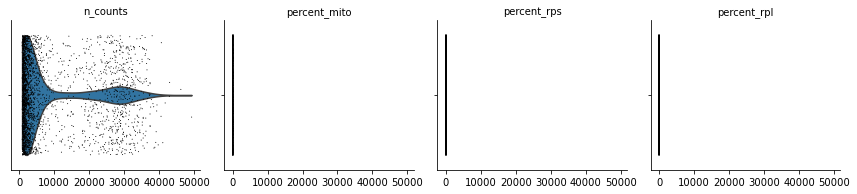

In [19]:
sc.pl.violin(adata, ['n_counts',"percent_mito",'percent_rps', 'percent_rpl'],
             jitter=0.4, multi_panel=True)

In [34]:
sc.pp.highly_variable_genes(adata,min_disp=-0.10,max_disp=np.inf)


In [32]:
adata

AnnData object with n_obs × n_vars = 2851 × 18158
    obs: 'n_genes', 'n_counts', 'percent_mito', 'percent_rps', 'percent_rpl'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

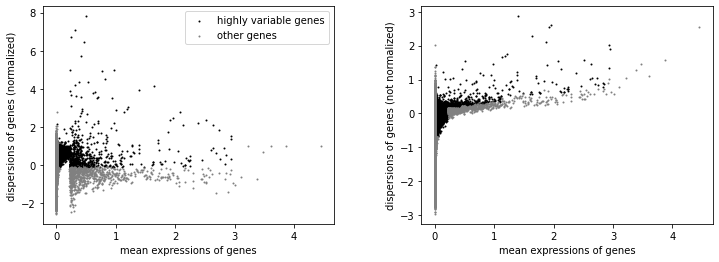

In [35]:
sc.pl.highly_variable_genes(adata,)